In [11]:
import vowpalwabbit
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np
from matplotlib.pyplot import figure

users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

def get_cost(context,action,switch):     
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics' and not switch:
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music' and not switch:
            return USER_LIKED_ARTICLE
        if context['time_of_day'] == "morning" and action == 'health' and switch:
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'camping' and switch:
            return USER_LIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports' and not switch:
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics' and not switch:
            return USER_LIKED_ARTICLE
        if context['time_of_day'] == "morning" and action == 'food' and switch:
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'finance' and switch:
            return USER_LIKED_ARTICLE
    
    return USER_DISLIKED_ARTICLE
        
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, switch_rewards, do_learn = True):
    cost_sum = 0.
    ctr = []
    random.seed(5)

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action, i > switch_rewards)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)), vowpalwabbit.LabelType.CONTEXTUAL_BANDIT)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])


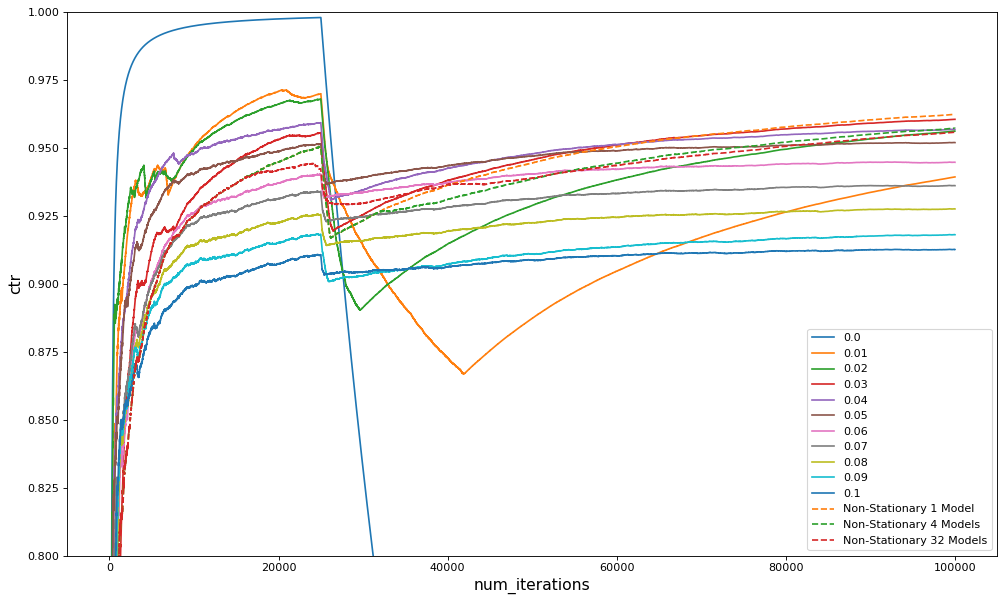

In [24]:
num_iterations = 100000
switch_rewards = 25000

leg = []
figure(figsize=(15, 9), dpi=80)

for ep in np.linspace(0,.1,11):
    vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --epsilon " + str(ep))
    ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
    plt.plot(range(1,num_iterations+1), ctr)
    leg.append(str(ep))

# Instantiate learner in VW non-stationary epsilon
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --agedexp --model_count 1")
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
plt.plot(range(1,num_iterations+1), ctr, "--")
leg.append("Non-Stationary 1 Model")

# Instantiate learner in VW non-stationary epsilon
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --agedexp --model_count 4")
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
plt.plot(range(1,num_iterations+1), ctr, "--")
leg.append("Non-Stationary 4 Models")

# Instantiate learner in VW non-stationary epsilon
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --agedexp --model_count 32")
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
plt.plot(range(1,num_iterations+1), ctr, "--")
leg.append("Non-Stationary 32 Models")

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([.8,1])
plt.legend(leg)

plt.show()

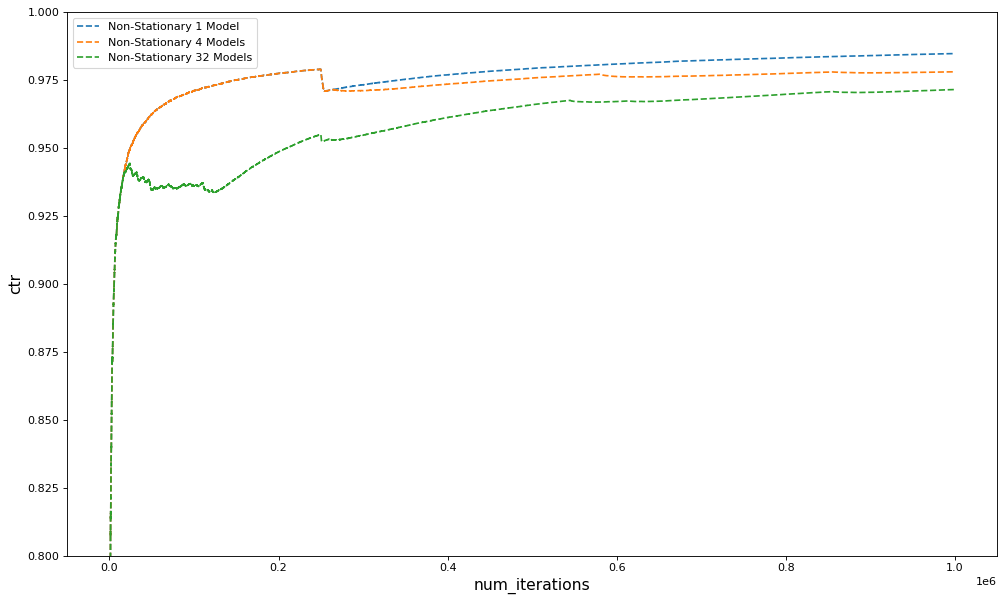

In [26]:
num_iterations = 1000000
switch_rewards = 250000

leg = []
figure(figsize=(15, 9), dpi=80)

# Instantiate learner in VW non-stationary epsilon
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --agedexp --model_count 1")
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
plt.plot(range(1,num_iterations+1), ctr, "--")
leg.append("Non-Stationary 1 Model")

# Instantiate learner in VW non-stationary epsilon
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --agedexp --model_count 4")
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
plt.plot(range(1,num_iterations+1), ctr, "--")
leg.append("Non-Stationary 4 Models")

# Instantiate learner in VW non-stationary epsilon
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --agedexp --model_count 32")
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, switch_rewards)
plt.plot(range(1,num_iterations+1), ctr, "--")
leg.append("Non-Stationary 32 Models")

plt.xlabel('num_iterations', fontsize=14)
plt.ylabel('ctr', fontsize=14)
plt.ylim([.8,1])
plt.legend(leg)

plt.show()